# Self-Driving Car Engineer Nanodegree
# Advanced Lane Lines

In this project we will revisit the lane line detection project using some more advanced computer vision techniques.

In [1]:
# Import packages.
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration

Before we begin detecting lane lines, we will need to calibrate the camera. This will allow us to correct for distortions in the images taken by the camera.

Camera distortion will be determined by looking for corners in a chessboard image taken from various angles. Loop through each of these calibration images to construct a mapping from image coordinates to real world coordinates.

In [2]:
# Prepare object points.
nx = 9 # The number of horizontal inside corners.
ny = 6 # The number of vertical inside corners.

# Arrays to store detected image points and object points.
objpoints = [] # 3D points in real world space.
imgpoints = [] # 2D points in image space.

# Prepare the object points. These will be the same for all images.
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Loop through the calibration images/
nb_images = 0
nb_detected = 0
for filename in os.listdir('camera_cal'):
    nb_images += 1
    # Load the calibration image.
    img = cv2.imread('camera_cal/' + filename)
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        nb_detected += 1
        # Add object points and image points.
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw detected corners on the image.
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    # Save the images, with corners annotated if found.
    cv2.imwrite('output_images/corners-' + filename, img)

# Print results of corner detection.
print('Successfully found corners in {} of {} calibration images.'.format(nb_detected, nb_images))

Successfully found corners in 17 of 20 calibration images.


## Distortion Correction

Now that the mappings from image space to the real world have been collected, we can use OpenCV to calculate the camer matrix and distortion coefficients. We can verify these values by undistorting the calibration images.

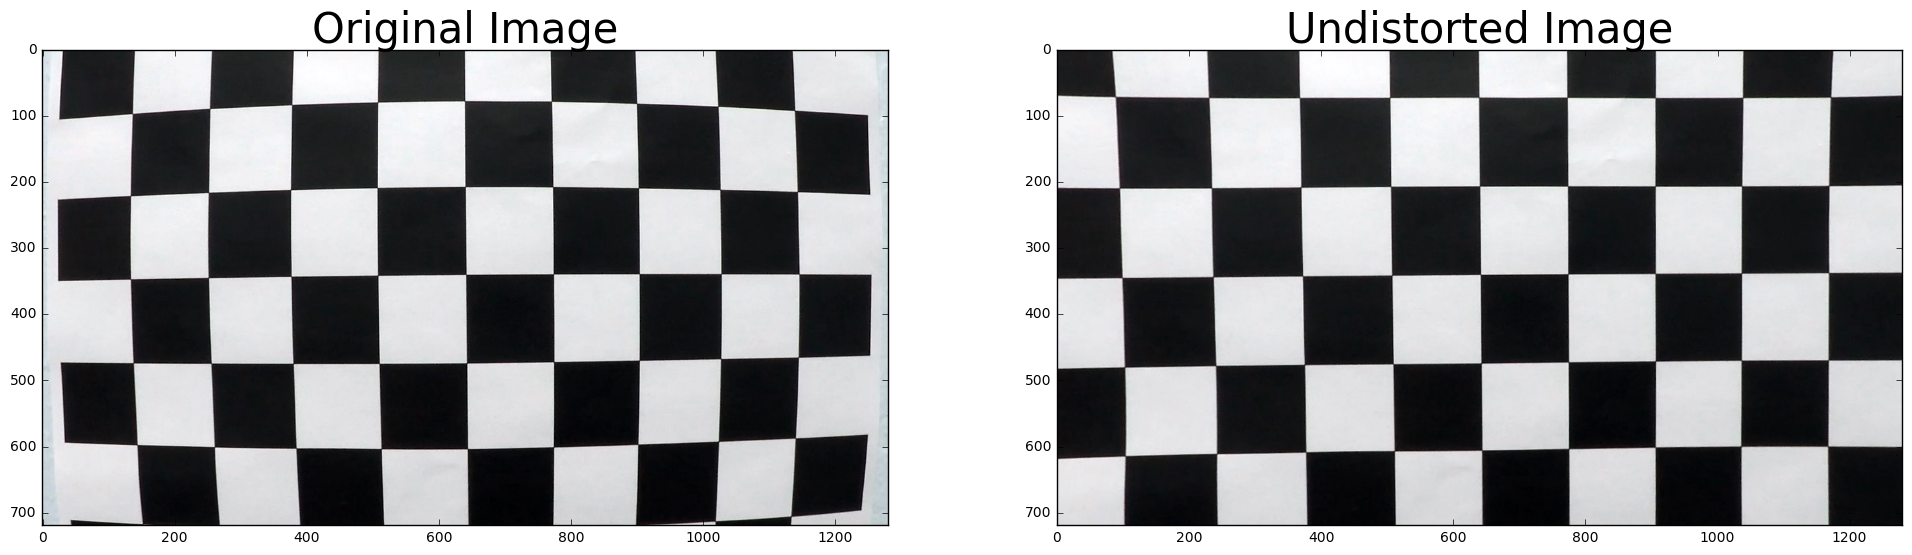

In [3]:
# Get the shape of the calibration images.
img = cv2.imread('camera_cal/calibration1.jpg')
shape = img.shape[0:2]

# Calculate the camera matrix and distortion coefficients.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)  

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

# Plot the original and undistorted images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
# Loop through the calibration images.
for filename in os.listdir('camera_cal'):
    # Load the calibration image.
    img = cv2.imread('camera_cal/' + filename)
    # Undistort the image.
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # Save the undistorted images.
    cv2.imwrite('output_images/undistorted-' + filename, img)

## Color/Gradient Thresholds

With distortion correction now solved, we can move on to work more directly with finding lanes. The next step will be to apply some mixture of color and gradient thresholding to identify points that likely belong to the lane line.

### HLS Color Thresholds

The BGR color representation that OpenCV uses natively to process images does not lend itself well to lane detection. Instead, we will convert the images into an alternative color space that is more robust to road conditions. In particular, the saturation channel of the HSL color space has shown itself to be particularly good at identifying both white and yellow lane lines under various lighting conditions. Unfortunately, saturation alone will also bring in a significant amount of shadows and other undesirable elements. We will therefore combine the saturation threshold with a lightness threshold that will filter out very dark elements.

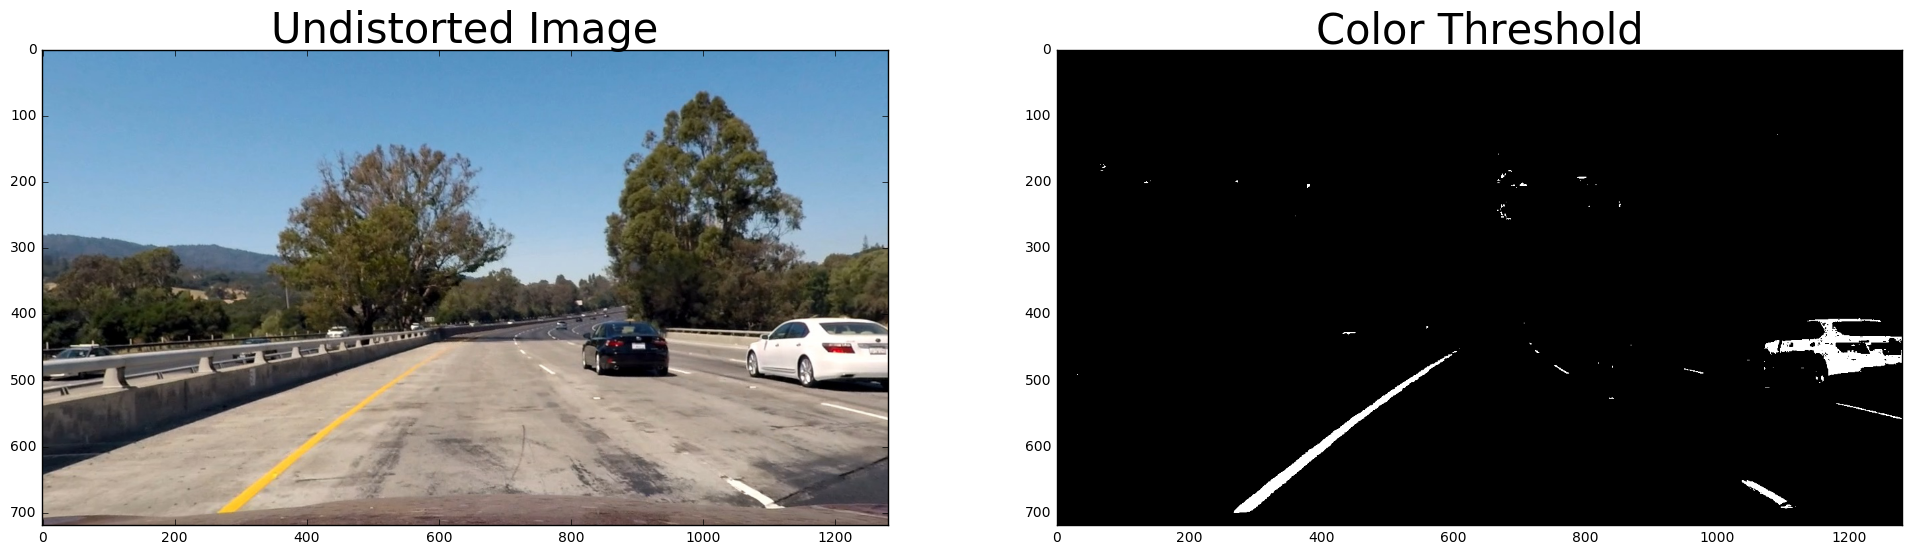

In [5]:
LIGHTNESS_THRESHOLD = (120, 255)
SATURATION_THRESHOLD = (140, 255)

def color_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(L > LIGHTNESS_THRESHOLD[0]) & (L <= LIGHTNESS_THRESHOLD[1]) &
           (S >= SATURATION_THRESHOLD[0]) & (S <= SATURATION_THRESHOLD[1])] = 1
    return binary

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = color_threshold(img)

# Plot the original and thresholded images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Color Threshold', fontsize=30)

Thresholding on the saturation and lightness channels in the HLS colorspace has done a good job of isolating both the yellow and white lane lines. 

In [6]:
# Loop through the test images and apply the saturation threshold.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = color_threshold(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/color-threshold-' + filename, img)

### Sobel Gradient Thresholds

In the first version of this project, we used Canny edge detection to isolate lanes lines. This worked well, but the algorithm found edges in both the horizontal and vertical directions. With Sobel filters we can work with the horizontal and vertical gradients separately. For this project, we will set very liberal thresholds for each gradient direction, but will then take the intersection of both. This worked remarkably well to isolate the lane lines while remove spurious noise that was present in one direction but not the other.

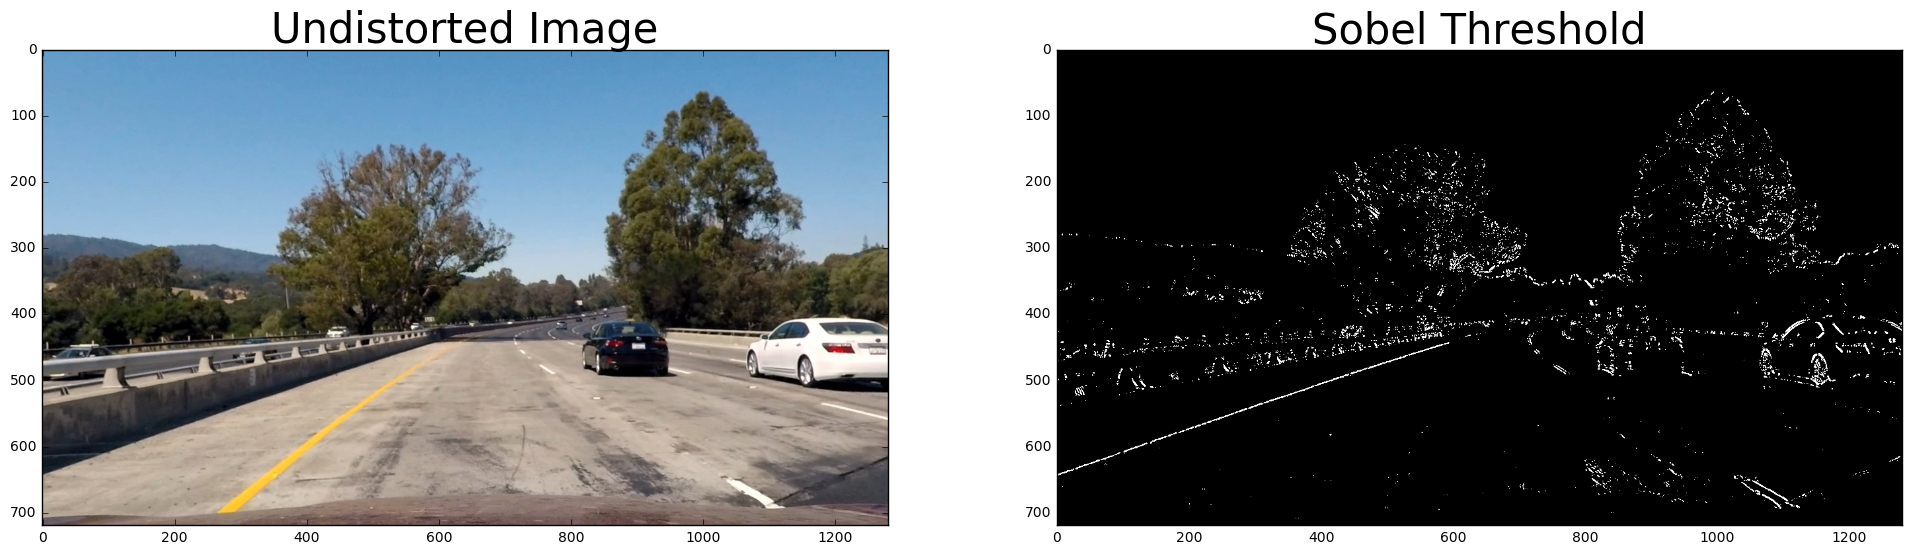

In [7]:
SOBEL_X_THRESHOLD = (25, 200)
SOBEL_Y_THRESHOLD = (25, 200)

def sobel_threshold(img, dir='x', thresh=SOBEL_X_THRESHOLD):
    if dir == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255. * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def combined_sobel(img):
    # Convert the image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Sobel thresholds.
    sobel_x = sobel_threshold(gray, 'x', SOBEL_X_THRESHOLD)
    sobel_y = sobel_threshold(gray, 'y', SOBEL_Y_THRESHOLD)
    # Combine the filters.
    binary = cv2.bitwise_and(sobel_x, sobel_y)
    return binary

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = combined_sobel(img)

# Plot the original and thresholded images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Sobel Threshold', fontsize=30)

The Sobel threshold filter didn't work as well with the washed out lines in this image as the color filter, but it did work better on other test images.

In [8]:
# Loop through the test images and apply the sobel threshold.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = combined_sobel(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/sobel-' + filename, img)

### Combined Thresholds

The color and sobel filters each performed differently based on various conditions of the images. Rather than relying on one or the other, we can combine the filters to produce a thresholding function that takes advantages of the unique properties of each.

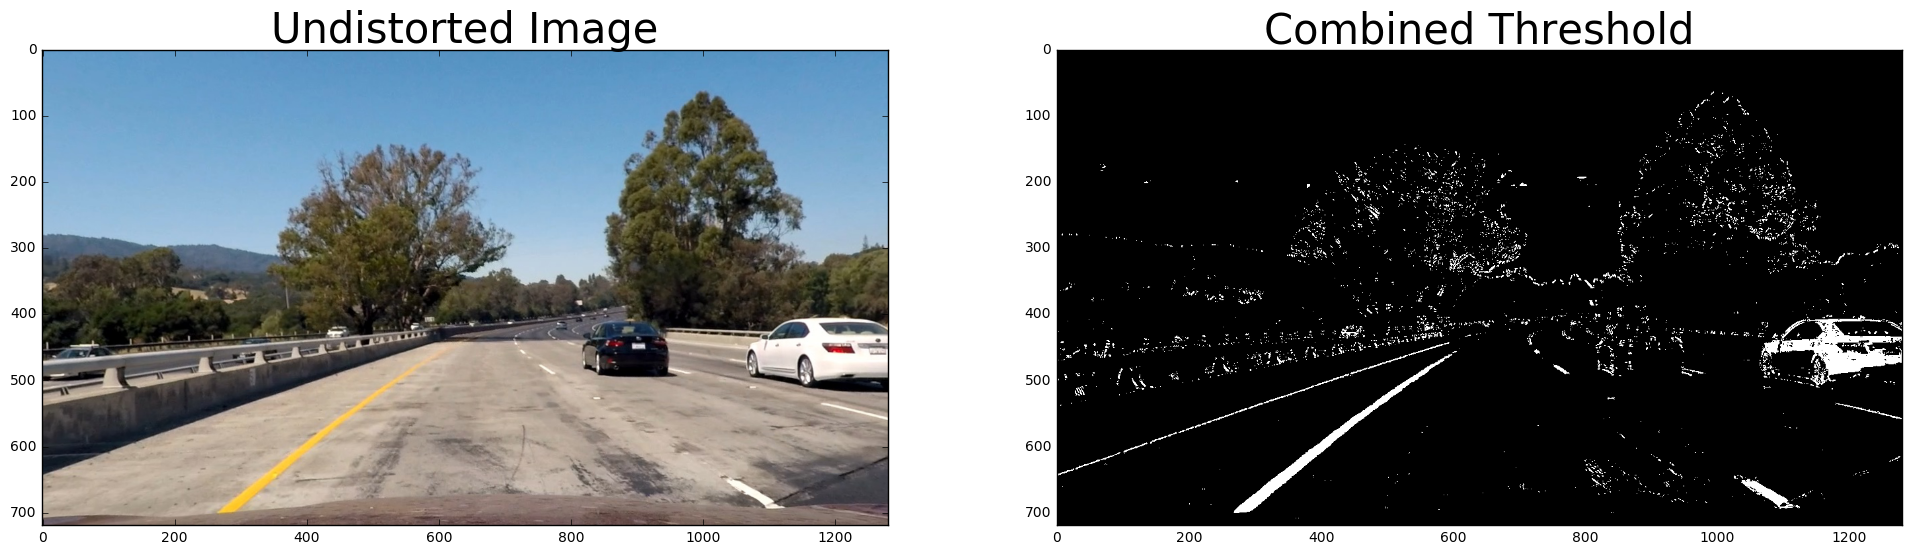

In [9]:
def combined_threshold(img):
    color_binary = color_threshold(img)
    sobel_binary = combined_sobel(img)
    binary = cv2.bitwise_or(color_binary, sobel_binary)
    return binary

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
dst = combined_threshold(img)

# Plot the original and thresholded images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=30)

By combining color based and gradient based thresholding techniques, we were able to isolate lane lines in images where neither technique alone would have been sufficient. While we could continue to try different types and combinations of thresholds, using just these two will give us a good start.

In [10]:
# Loop through the test images amd apply the combined threshold.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = combined_threshold(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/combined-threshold-' + filename, img)

## Perspective Transform

To simplify the detection of lane lines as well as to compute the radius of curvature, we will create a perspective transform that will warp the images so that they appear as if we were looking at them from above.

The test images all feature various degrees of curving roads, which makes it hard to identify points that can be used to define the transform. Instead of using the provided test images, we scanned through the project video to find a relatively straight section of road to identify source points for the transform. This new image has been saved to the ```test_images``` directory as ```straight.jpg```.

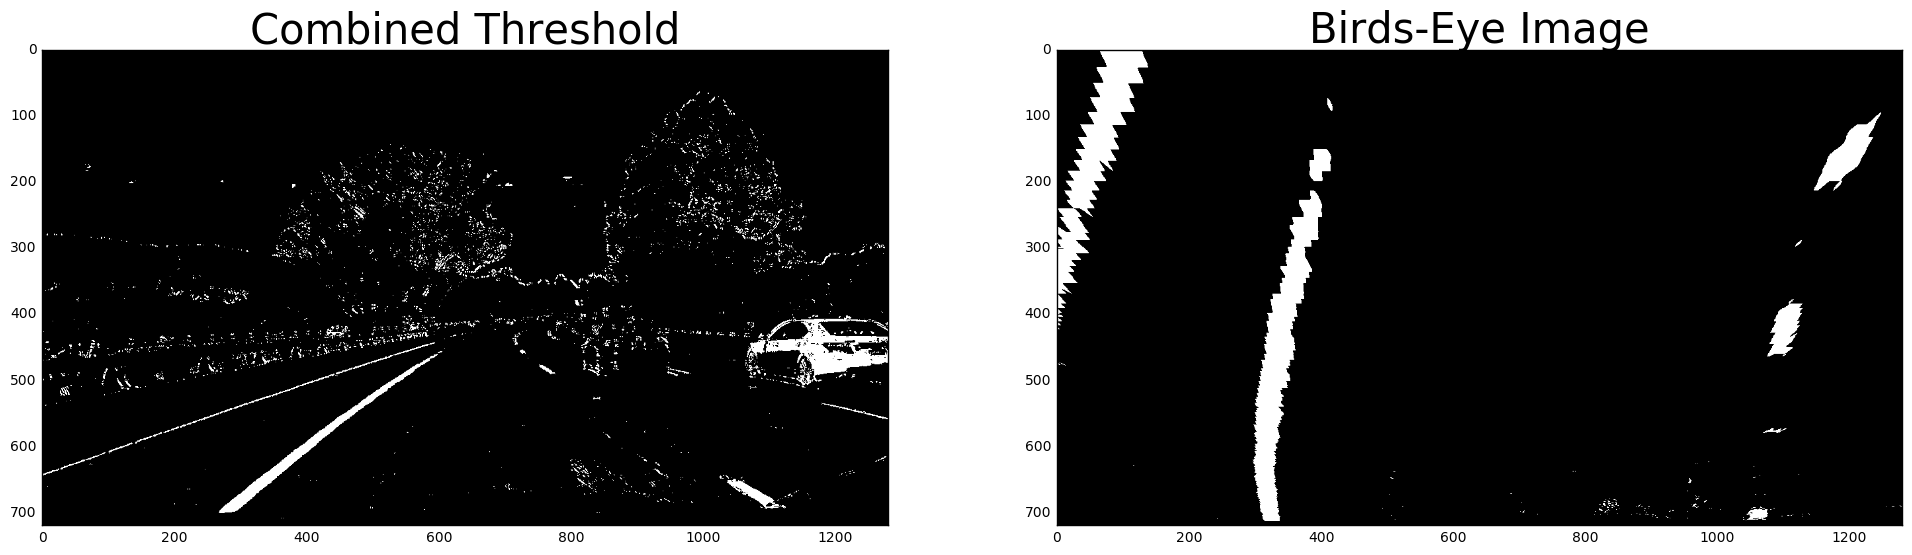

In [11]:
PERSPECTIVE_SRC_POINTS = np.float32([[100, 719], [494, 500], [785, 500], [1179, 719]])
PERSPECTIVE_DST_POINTS = np.float32([[200, 719], [200, 500], [1079, 500], [1079, 719]])
M = cv2.getPerspectiveTransform(PERSPECTIVE_SRC_POINTS, PERSPECTIVE_DST_POINTS)
Minv = cv2.getPerspectiveTransform(PERSPECTIVE_DST_POINTS, PERSPECTIVE_SRC_POINTS)

def warp(img):
    image_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)

def unwarp(img):
    image_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, Minv, image_size, flags=cv2.INTER_LINEAR)

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
img = combined_threshold(img)
dst = warp(img)

# Plot the original and warped images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img, cmap='gray')
ax1.set_title('Combined Threshold', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Birds-Eye Image', fontsize=30)

In [12]:
# Loop through the test images amd apply the perspective transform.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = combined_threshold(img)
    img = warp(img)
    # Convert from binary to grayscale before saving.
    img *= 255
    cv2.imwrite('output_images/warp-' + filename, img)

## Finding Lane Lines

### Histogram

To first detect a starting point for the lane lines, we will create a histogram of possible points in the lower half of the warped image. The points in the lower half of the screen haven't been as distorted by the transform to the birds-eye view and are more likely to be closer to vertical, which will help keep the width of the histogram peaks small and better localized.

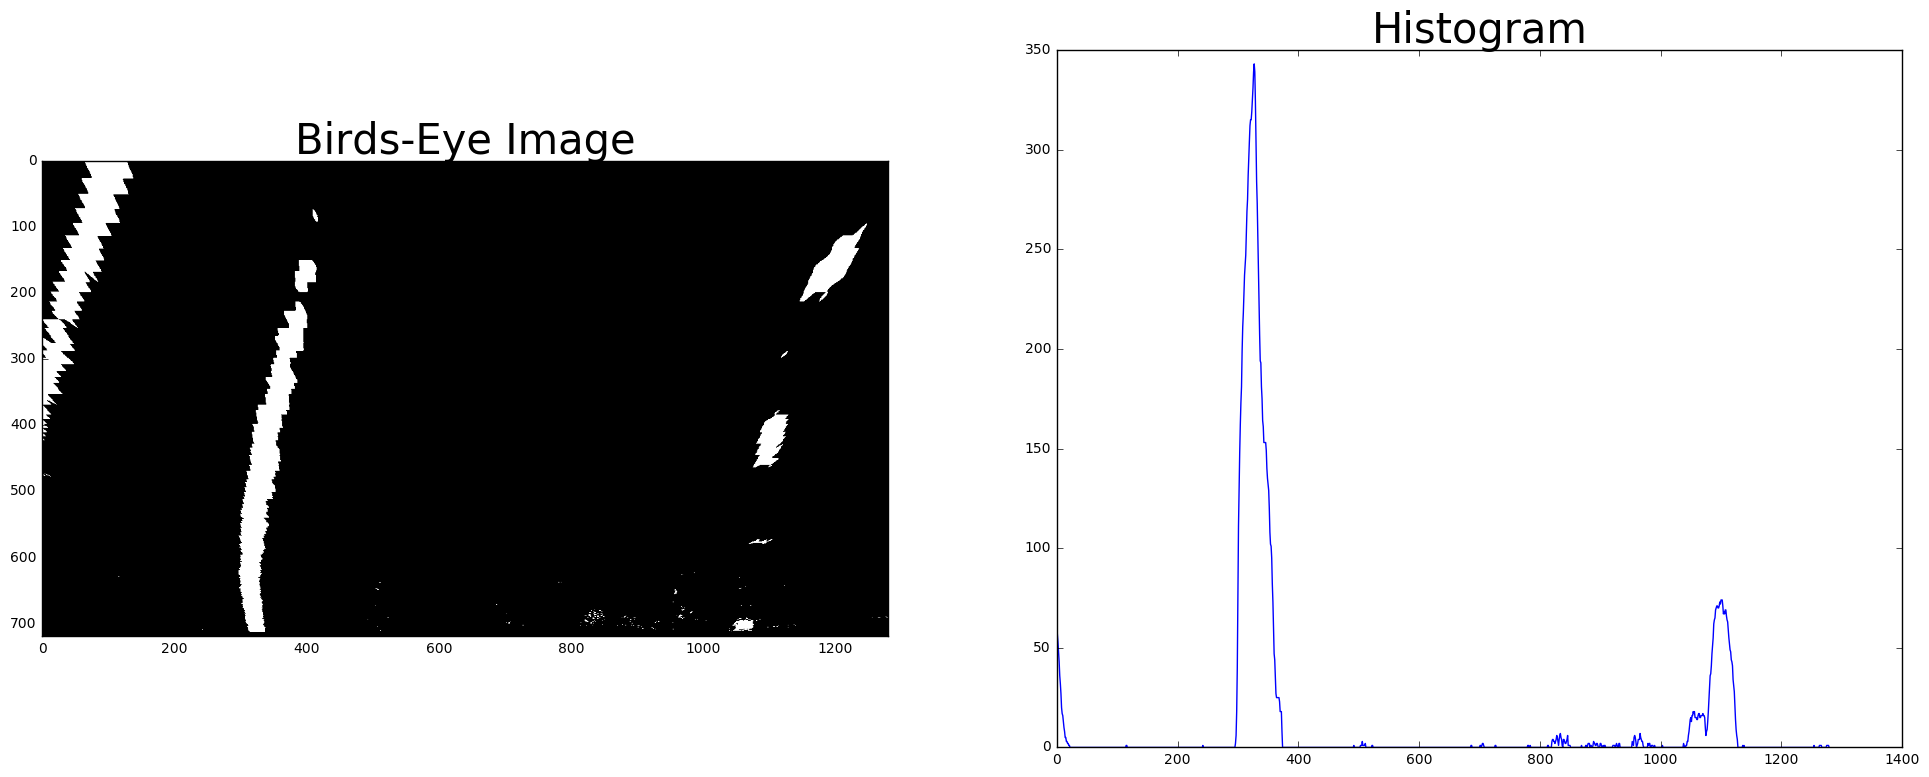

In [13]:
def histogram(img):
    return np.sum(img[img.shape[0]/2:,:], axis=0)

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
img = combined_threshold(img)
img = warp(img)
hist = histogram(img)

# Plot the original and histogram images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img, cmap='gray')
ax1.set_title('Birds-Eye Image', fontsize=30)
ax2.plot(hist)
ax2.set_title('Histogram', fontsize=30)

In [14]:
# Loop through the test images amd apply the perspective transform.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = warp(img)
    img = combined_threshold(img)
    hist = histogram(img)
    plt.title('Histogram')
    plt.plot(hist)
    plt.savefig('output_images/histogram-' + filename, bbox_inches='tight')
    plt.close()

### Detecting Lane Lines

We have now applied all of the thresholding, transformations, and histograms and are ready to try to detect the lane lines. We will use a utility class to track the progress of the detection of each lane and pass that information along to help speed up detection in subsequent frames.

In [15]:
# Dimensions of sliding window to search for lane points.
SLIDING_WINDOW_WIDTH = 100
SLIDING_WINDOW_HEIGHT = 90

# Conversion of pixels to meters were estimated from the birds-eye
# project of the straight lane images. Federal regulations require
# lane width to be at least 3.7m wide, which maps to approximately
# 730px. Dashed lines are 10m long, or 80px in our projection.
X_METERS_PER_PIXEL = 3.7 / 730.
Y_METERS_PER_PIXEL = 36. / 720.

# Number of frames to smooth over.
N_FRAMES = 6

# Maximum number of bad frames to skip before rejecting detection
# and starting from scratch.
N_SKIPS = 2

# The cosine similarity of the new fit to the average of the previous
# fits must be within this range or the new fit will be discarded.
FIT_TOLERANCE = 0.98

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #was the line detected in the last iteration?
        self.detected = False
        #number of consecutive frames skipped
        self.frames_skipped = 0
        #polynomial coefficients for the last n iterations
        self.previous_fits = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = None  
        #curvature for the last n iterations
        self.previous_radius_of_curvatures = []
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
    def reject(self):
        self.detected = False
        self.frames_skipped = 0
        self.previous_fits = []
        self.previous_radius_of_curvatures = []
        
def fit_point(y, line):
    # The lane fit is in meters, so we need to convert from pixel
    # values to meters and then back again.
    ym = y * Y_METERS_PER_PIXEL
    xm = line.current_fit[2] + line.current_fit[1]*ym + line.current_fit[0]*ym*ym
    return int(xm / X_METERS_PER_PIXEL)
        
def detect_lane(img, line, xmin, xmax):
    if line.detected:
        # A line was detected in a previous frame, so we can start
        # search for the new line within a sliding window around the
        # old one.
        xstart = fit_point(img.shape[0] - 1, line)
    else:
        # If we haven't found a lane line yet, start with the peak
        # of the histogram as the best guess.
        hist = histogram(img)
        xstart = xmin + np.argmax(hist[xmin:xmax])
    
    # Process sliding windows of points.
    xleft = xstart - SLIDING_WINDOW_WIDTH // 2
    ybottom = img.shape[0]
    allx = []
    ally = []
    while ybottom > 0:
        # clip the sliding window start to the bounds of the image.
        xleft = min(max(xmin, xleft), xmax)
        xright = min(xleft + SLIDING_WINDOW_WIDTH, xmax)
        ytop = max(0, ybottom - SLIDING_WINDOW_HEIGHT)

        # Loop through every pixel in the sliding window to see if
        # it should be added to the candidate line.
        xvalues = []
        for y in range(ytop, ybottom):
            for x in range(xleft, xright):
                if img[y][x] > 0:
                    xvalues.append(x)
                    allx.append(x)
                    ally.append(y)

        # Move the sliding window up and recenter it on the mean
        # x value of the detected points.
        ybottom -= SLIDING_WINDOW_HEIGHT
        if len(xvalues) > 0:
            xleft = int(np.mean(xvalues) - SLIDING_WINDOW_WIDTH // 2)
    
    # Check to see if we detected at least a reasonable number of candidate
    # points for the line. Otherwise just reuse the previously fit line and
    # trigger a full scan on the next frame.
    if len(allx) < 100:
        line.reject()
    else:
        # Calculate coefficients and radius of curve fit to detected points.
        allx = np.array(allx)
        ally = np.array(ally)
        coeffs = np.polyfit(ally*Y_METERS_PER_PIXEL, allx*X_METERS_PER_PIXEL, 2)
        
        # Make sure the new curve doesn't fall too far away from the current average
        # fit of the recent frames.
        if len(line.previous_fits) > 0:
            previous_fit_norm = line.current_fit / np.linalg.norm(line.current_fit)
            coeffs_norm = coeffs / np.linalg.norm(coeffs)
            fit_sim = np.dot(previous_fit_norm, coeffs_norm)
            if fit_sim < FIT_TOLERANCE:
                # Fit error exceeds tolerance, so skip update and continue to
                # use the previous fit.
                line.frames_skipped += 1
                if line.frames_skipped > N_SKIPS:
                    # We skipped too many frames, so reject the current line parameters
                    # and start from scratch next time.
                    line.reject()
                return
                
        # Evaluate radius at bottom of image.
        y_eval = (img.shape[0] - 1) * Y_METERS_PER_PIXEL
        radius = ((1 + (2*coeffs[0]*y_eval + coeffs[1])**2)**1.5)/np.absolute(2*coeffs[0])
        # Calculate distance from center
        xline = coeffs[2] + coeffs[1]*y_eval + coeffs[0]*y_eval*y_eval
        xcenter = X_METERS_PER_PIXEL * img.shape[1] / 2.
        base_pos = abs(xline - xcenter)
        
        # Add the newly fit line to the previous lines and the compute the
        # average to use as the smoothed line for this frame.
        line.previous_fits.append(coeffs)
        line.previous_fits = line.previous_fits[-N_FRAMES:]
        coeffs = np.average(line.previous_fits, axis=0)
        
        # Add the newly fit radius of curvature to the previous values and
        # compute the averaage to use as the smoothed radius.
        line.previous_radius_of_curvatures.append(radius)
        line.previous_radius_of_curvatures = line.previous_radius_of_curvatures[-N_FRAMES:]
        radius = np.average(line.previous_radius_of_curvatures, axis=0)
                
        # Save line parameters.
        line.detected = True
        line.frames_skipped = 0
        line.current_fit = coeffs
        line.radius_of_curvature = radius
        line.line_base_pos = base_pos

def detect_lanes(img, left_line, right_line):
    # Find the center point of the image. For now we will assume that the
    # car won't change lanes so that we can look for the left lane in the
    # left half of the image and the right lane in the right half.
    detect_lane(img, left_line, 0, img.shape[1] // 2 - 1)
    detect_lane(img, right_line, img.shape[1] // 2, img.shape[1] - 1)

### Draw the Lane Mask

Once we have detected the lanes and fit polynomial equations to their points, we can use those polynomials to fill the space between those curves to show the area covered by the lane on the road. Later we can take this mask and unwarp it back to the camera's point of view and overlay it on the original image of the road.

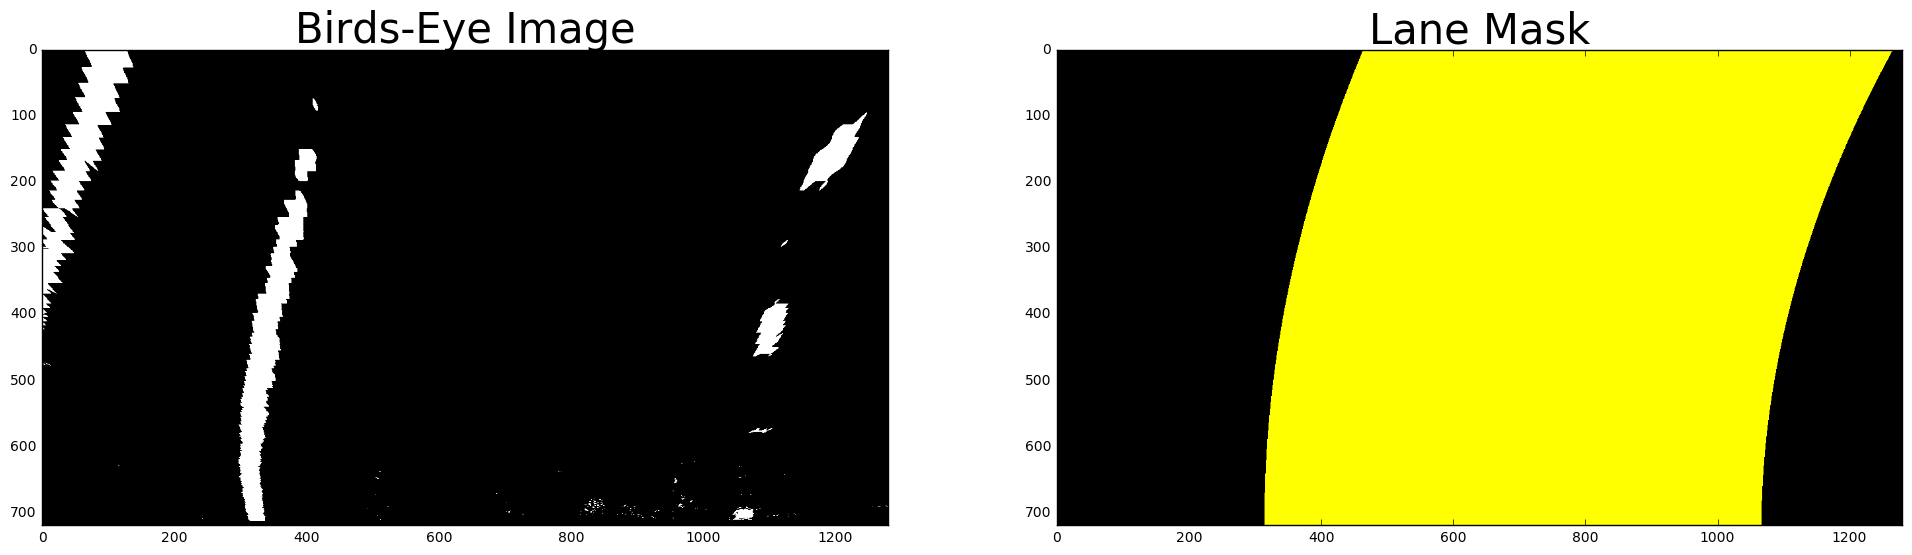

In [16]:
def draw_mask(img, left_line, right_line):
    channel_zeros = np.zeros_like(img).astype(np.uint8)
    mask = np.dstack((channel_zeros, channel_zeros, channel_zeros))
    for y in range(img.shape[0]):
        xleft = fit_point(y, left_line)
        xright = fit_point(y, right_line)
        cv2.line(mask, (xleft, y), (xright, y), (0, 255, 255))
    return mask

img = cv2.imread('test_images/test1.jpg')
img = undistort(img)
img = combined_threshold(img)
img = warp(img)

left_line = Line()
right_line = Line()
detect_lanes(img, left_line, right_line)
mask = draw_mask(img, left_line, right_line)

# Plot the original and warped images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img, cmap='gray')
ax1.set_title('Birds-Eye Image', fontsize=30)
ax2.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
ax2.set_title('Lane Mask', fontsize=30)

Although not entirely perfect, the generated lane masks are roughly parallel and curving in the right direction. Average the lane masks over several frames should help smooth out some of the inconsistencies.

In [17]:
# Loop through the test images and generate the lane mask.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    img = undistort(img)
    img = combined_threshold(img)
    img = warp(img)
    
    left_line = Line()
    right_line = Line()
    detect_lanes(img, left_line, right_line)
    mask = draw_mask(img, left_line, right_line)
    cv2.imwrite('output_images/mask-' + filename, mask)

## Image Processing Pipeline

The image processing pipeline will form the basis of the lane lines detection. The pipeline will combine all of the steps developed above to process a single image or frame of video. Once the image has been assembled, it will be annotated with the curvature of the lane and the distance of the car from the center of the lane.

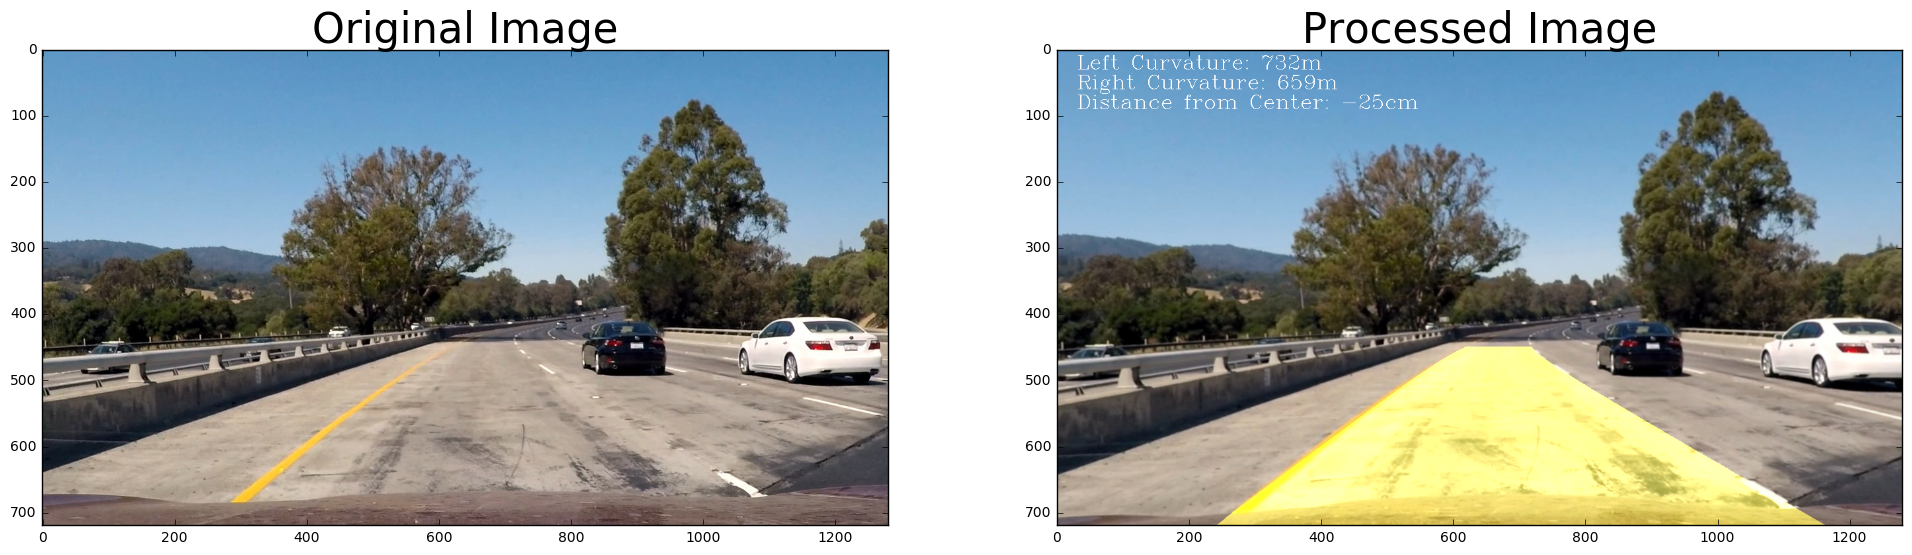

In [18]:
class FrameData:
    def __init__(self):
        self.frame_count = 0
        self.left_curvature = 0
        self.right_curvature = 0
        self.offset = 0

def pipeline(img, left_line, right_line, frame_data=None):
    # Create FrameData object if none passed in.
    if frame_data is None:
        frame_data = FrameData()
    # Undistort the image to correct for camera distortions.
    img = undistort(img)
    # Apply a Gaussian blur to smooth out the image.
    img = cv2.GaussianBlur(img,(3, 3), 0)
    # Apply thresholds to isolate potential lane line points.
    thresh = combined_threshold(img)
    # Warp the perspective to a birds-eye view 
    warped = warp(thresh)
    # Detect the lane lines
    detect_lanes(warped, left_line, right_line)
    # Draw the lane mask.
    warped_mask = draw_mask(warped, left_line, right_line)
    # Unwarp the lane mask and convert it to the expected RGB colorspace.
    mask = unwarp(warped_mask)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    # Combine the original image with the lane mask.
    combined = cv2.addWeighted(mask, 0.4, img, 1., 0.)
    # Periodically update the curvature and offset from center.
    if frame_data.frame_count % 5 == 0:
        frame_data.left_curvature = int(left_line.radius_of_curvature)
        frame_data.right_curvature = int(right_line.radius_of_curvature)
        frame_data.offset = int(100. * (left_line.line_base_pos - right_line.line_base_pos) / 2.)
    # Advance frame count.
    frame_data.frame_count += 1
    # Annotate lane curvature and distance from center.
    combined = cv2.putText(combined, 'Left Curvature: %dm' % frame_data.left_curvature, (30, 30), cv2.FONT_HERSHEY_COMPLEX, 1., (255, 255, 255))
    combined = cv2.putText(combined, 'Right Curvature: %dm' % frame_data.right_curvature, (30, 60), cv2.FONT_HERSHEY_COMPLEX, 1., (255, 255, 255))
    combined = cv2.putText(combined, 'Distance from Center: %dcm' % frame_data.offset, (30, 90), cv2.FONT_HERSHEY_COMPLEX, 1., (255, 255, 255))
    # Return the processed image.
    return combined

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = pipeline(img, Line(), Line())

# Plot the original and processed images.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Processed Image', fontsize=30)

In [19]:
# Loop through the test images and apply the pipeline.
for filename in os.listdir('test_images'):
    img = cv2.imread('test_images/' + filename)
    left_line = Line()
    right_line = Line()
    img = pipeline(img, Line(), Line())
    cv2.imwrite('output_images/pipeline-' + filename, img)

## Video Pipeline

Now all the steps are in place to detect lines in the videos. First we will generate a callable lambda expression that the movie writer can use to send each image through the image pipeline before writing the processed image to the new video file.

In [20]:
def process_image():
    left_line = Line()
    right_line = Line()
    frame_data = FrameData()
    return (lambda img: pipeline(img, left_line, right_line, frame_data=frame_data))

for filename in ['project_video.mp4', 'challenge_video.mp4', 'harder_challenge_video.mp4']:
    clip = VideoFileClip(filename)
    out = clip.fl_image(process_image())
    out.write_videofile('processed-' + filename, audio=False)
    

[MoviePy] >>>> Building video processed-project_video.mp4
[MoviePy] Writing video processed-project_video.mp4


100%|█████████▉| 1260/1261 [06:25<00:00,  3.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-project_video.mp4 

[MoviePy] >>>> Building video processed-challenge_video.mp4
[MoviePy] Writing video processed-challenge_video.mp4


100%|██████████| 485/485 [02:13<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-challenge_video.mp4 

[MoviePy] >>>> Building video processed-harder_challenge_video.mp4
[MoviePy] Writing video processed-harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [06:02<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed-harder_challenge_video.mp4 



## Results

The processed videos can be found in the main directory.

* ```processed-project_video.mp4```: The project video.
* ```processed-challenge_video.mp4```: The first challenge video.
* ```processed-harder_challenge_video.mp4```: The harder challenge video.

As can be seen from the videos above, the main project video is able to fairly accurately track the progress of the car. The thresholding and line fitting techniques used, however, are still not sophisticated enough to handle the more challenging videos with their harsher driving conditions.

Intermediate progress images were saved as the pipeline was being developed. They can be examined to see the effect of each transformation as the pipeline progresses. These images are stored in the ```output_images``` directory.

* ```corners-calibration-*.jpg```: The camera calibration images showing the detected corners. Not all of the images were able to have their corners dected.
* ```undistorted-calibration-*.jpg```: The camera calibration images after the undistorting them to remove camera artifacts.
* ```color-threshold-*.jpg```: The test images after the lightness and saturation thresholds have been applied to the HLS representation of the images.
* ```sobel-*.jpg```: The test images after the sobel edge filters have been applied.
* ```combined-threshold-*,jpg```: The test images after the saturation threshold and sobel filter thresholds have been applied.
* ```warp-*.jpg```: The thresholded images after being warped into a birds-eye perspective.
* ```histogram-*.jpg```: A histogram of x values in the lower half of the birds-eye images. These are used to bootstrap the detection of the start of the lane lines.
* ```mask-*.jpg```: The mask that will be drawn over the line as it was drawn from the birds-eye perspective.
* ```pipeline-*.jpg```: The final result after apply all of the image transformations to the test images.

## Observations

The project was considerably more difficult than the first lane detection project. However, the advanced computer vision techniques were able to provide much more information to the self-driving car. These techniques were able to detect curved lanes and and make some estimates on the amount of curvature and how far away the car had drifted from the center of the lane.

Unfortunately, the success of these computer vision technique are highly dependent on selecting the best filters and transformation as well as accurately tuning the various parameters of those algorithms. It would be nice to avoid all of this work by training a deep learning network to find and tune the parameters itself.

### Problems & Issues Faced

The biggest challenge we faced was finding a good set of filters and threshold values that would isolate lane lines without introducing unnecessary noise. In particular, while several techniques were tried that were succeful identifying points near the car, many of them failed to detect points further toward the horizon. Without identifying points along the entire span of the lane it was difficult to find to calculate the true curvature of the lane.

Another challenge while accurately calculating the curvature and position of the lane relative to the car. While finding a curves to fit the detected points was fairly straightforward, using them to calculate the offset of the car within the lane and the radius of curvature was more problematic. Part of this was because the source and destination points used to define the perspective transform were not well calibrated. Part of it was also because the conversion between pixels and distance were only roughly estimated.

### What Could Be Improved

The pipeline could use better thresholding techniques that can identify lane lines without also including unnecessary noise. One technique that could be explored further is finding multiple ways to detect the lane lines and then taking the intersection of their results. This was used effectively with the Sobel filters to find parts of the screen that had edges in both the horizontal and vertical directions. This removes things like shadows from the trees which have softer edges.

The perspective transform that warps the street image into a birds-eye view can introduce a significant amount of distortion artifacts if the lane detection and thresholding steps include significant amount of noise especially in the top portions of the image. This makes it particularly difficult to distinguish pixels belong to the lane when applying the sliding windows. At best this merely increases the computational complexity of calculating the curve. Unfortunately, most of the time this can can skew the calculation of the curve to return incorrect results.

The sliding window technique used to search for points belonging to the lane lines is fairly naive and susceptible to being skewed by random noise present in the image. More advanced techniques could be used, such as curve fitting algorithms that are less affected outliers in the samples.

Averaging the result of multiple frames helps smooth some of the rough edges of the pipeline. Taken too far, however, this can reduce the responsiveness and accuracy of the lane detection. More work is needed to figure out the best way smooth results without introducing noticeable smoothing artifacts in the video.

### Where the Pipeline Can Fail

The pipeline deveoped for this project has been tuned to the particular features of the project video and might not generalize to other conditions. The results of the challenge videos clearly show some of the limitations of the pipeline. Some potential situations where the pipeline can fail are:

* If the edge of the road is marked by multiple lines, the pipeline has no way of distinguishing which is the correct line demarcating the actual line. The histogram used will pick whichever one yields the strongest peak. And depending on how discriminating the sliding window algorithm is, points from both lines may be picked up as candidate lane points.
* The lane fitting assumes that the lane can be described with a simple quadratic curve. However, roads with significant winding and weaving  will not be classified properly.
* Weather conditions can make detection more difficult. For example, the steps used to remove the effects of shadows during the day could cause detection to fail entirely in the evening.
* Lens flare caused by driving into direct sunlight or other camera artifacts can make it more difficult to discern the actual features of the road.
* Road repairs, guard rails, medians, or other features with long, hard edges can be confused with lane lines.